This is based on https://cookbook.openai.com/examples/parse_pdf_docs_for_rag

In [5]:
# Imports
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from pdfminer.high_level import extract_text
import base64
import io
import os
import concurrent.futures
from tqdm import tqdm
from openai import OpenAI
import re
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np
from rich import print
from ast import literal_eval
from PyPDF2 import PdfReader
from mnt.ingest.convert_pptx import convert_all_pptx_to_pdf
# testing
# ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIAVTf2S9XsQNlKNHmSCw7vf22YleSqwegV8xUNWTs/yE ross.schrader@wwt.com

## File Processing

In [6]:
def convert_doc_to_images(path, chunk_size=2):
    
    reader = PdfReader(path)
    total_pages = len(reader.pages)

    all_images = []
    for start_page in range(1, total_pages + 1, chunk_size):
        end_page = min(start_page + chunk_size - 1, total_pages)
        images = convert_from_path(
            path,
            first_page=start_page,
            last_page=end_page,
            dpi = 50
        )
        all_images.extend(images)

    return all_images
    return images

def extract_text_from_doc(path):
    text = extract_text(path)
    return text

## Test

In [7]:
fpath = '/domino/datasets/local/Gartner_Article_Chat'

convert_all_pptx_to_pdf(fpath)

files = [os.path.join(fpath, f) for f in os.listdir(fpath) if (os.path.isfile(os.path.join(fpath, f)) & (f.split(".")[-1] == "pdf"))]

images = convert_from_path(files[0])

text = extract_text_from_doc(files[0])

In [8]:
text

'IT Key Metrics Data 2025: Industry Measures —\nInsurance Analysis\n\n5 December 2024 - ID G00822073 - 10 min read\n\nBy:\xa0Eric Stegman, Jamie Guevara, Shaivya Kaushal, Aditi Sharma\nInitiatives:CIO Digital Leadership; Technology Finance, Risk and Value Management\n\nGartner collects IT Spending and Stafﬁng data from the IT Budget\n\nTool and other sources on a year round basis. This analysis\nprovides insight into metrics for the Insurance Industry from that\n\ndataset. CIOs and IT Leaders should measure and benchmark\n\ntheir organization’s IT metrics using the IT Budget Tool. These\nbenchmarks can be part of a program to improve cost\n\nmanagement through transparency and regular calibration as a\n\nbest practice.\n\nGartner, Inc. | G00822073\n\nPage 1 of 26\n\nThis research note is restricted to the personal use of wesley.palmer@wwt.com.\n\n\x0cOverview\n\nFigure 1: Executive Summary for Insurance\n\nKey Findings\n\n■\n\n■\n\n■\n\n■\n\nAll of the metrics published in this report 

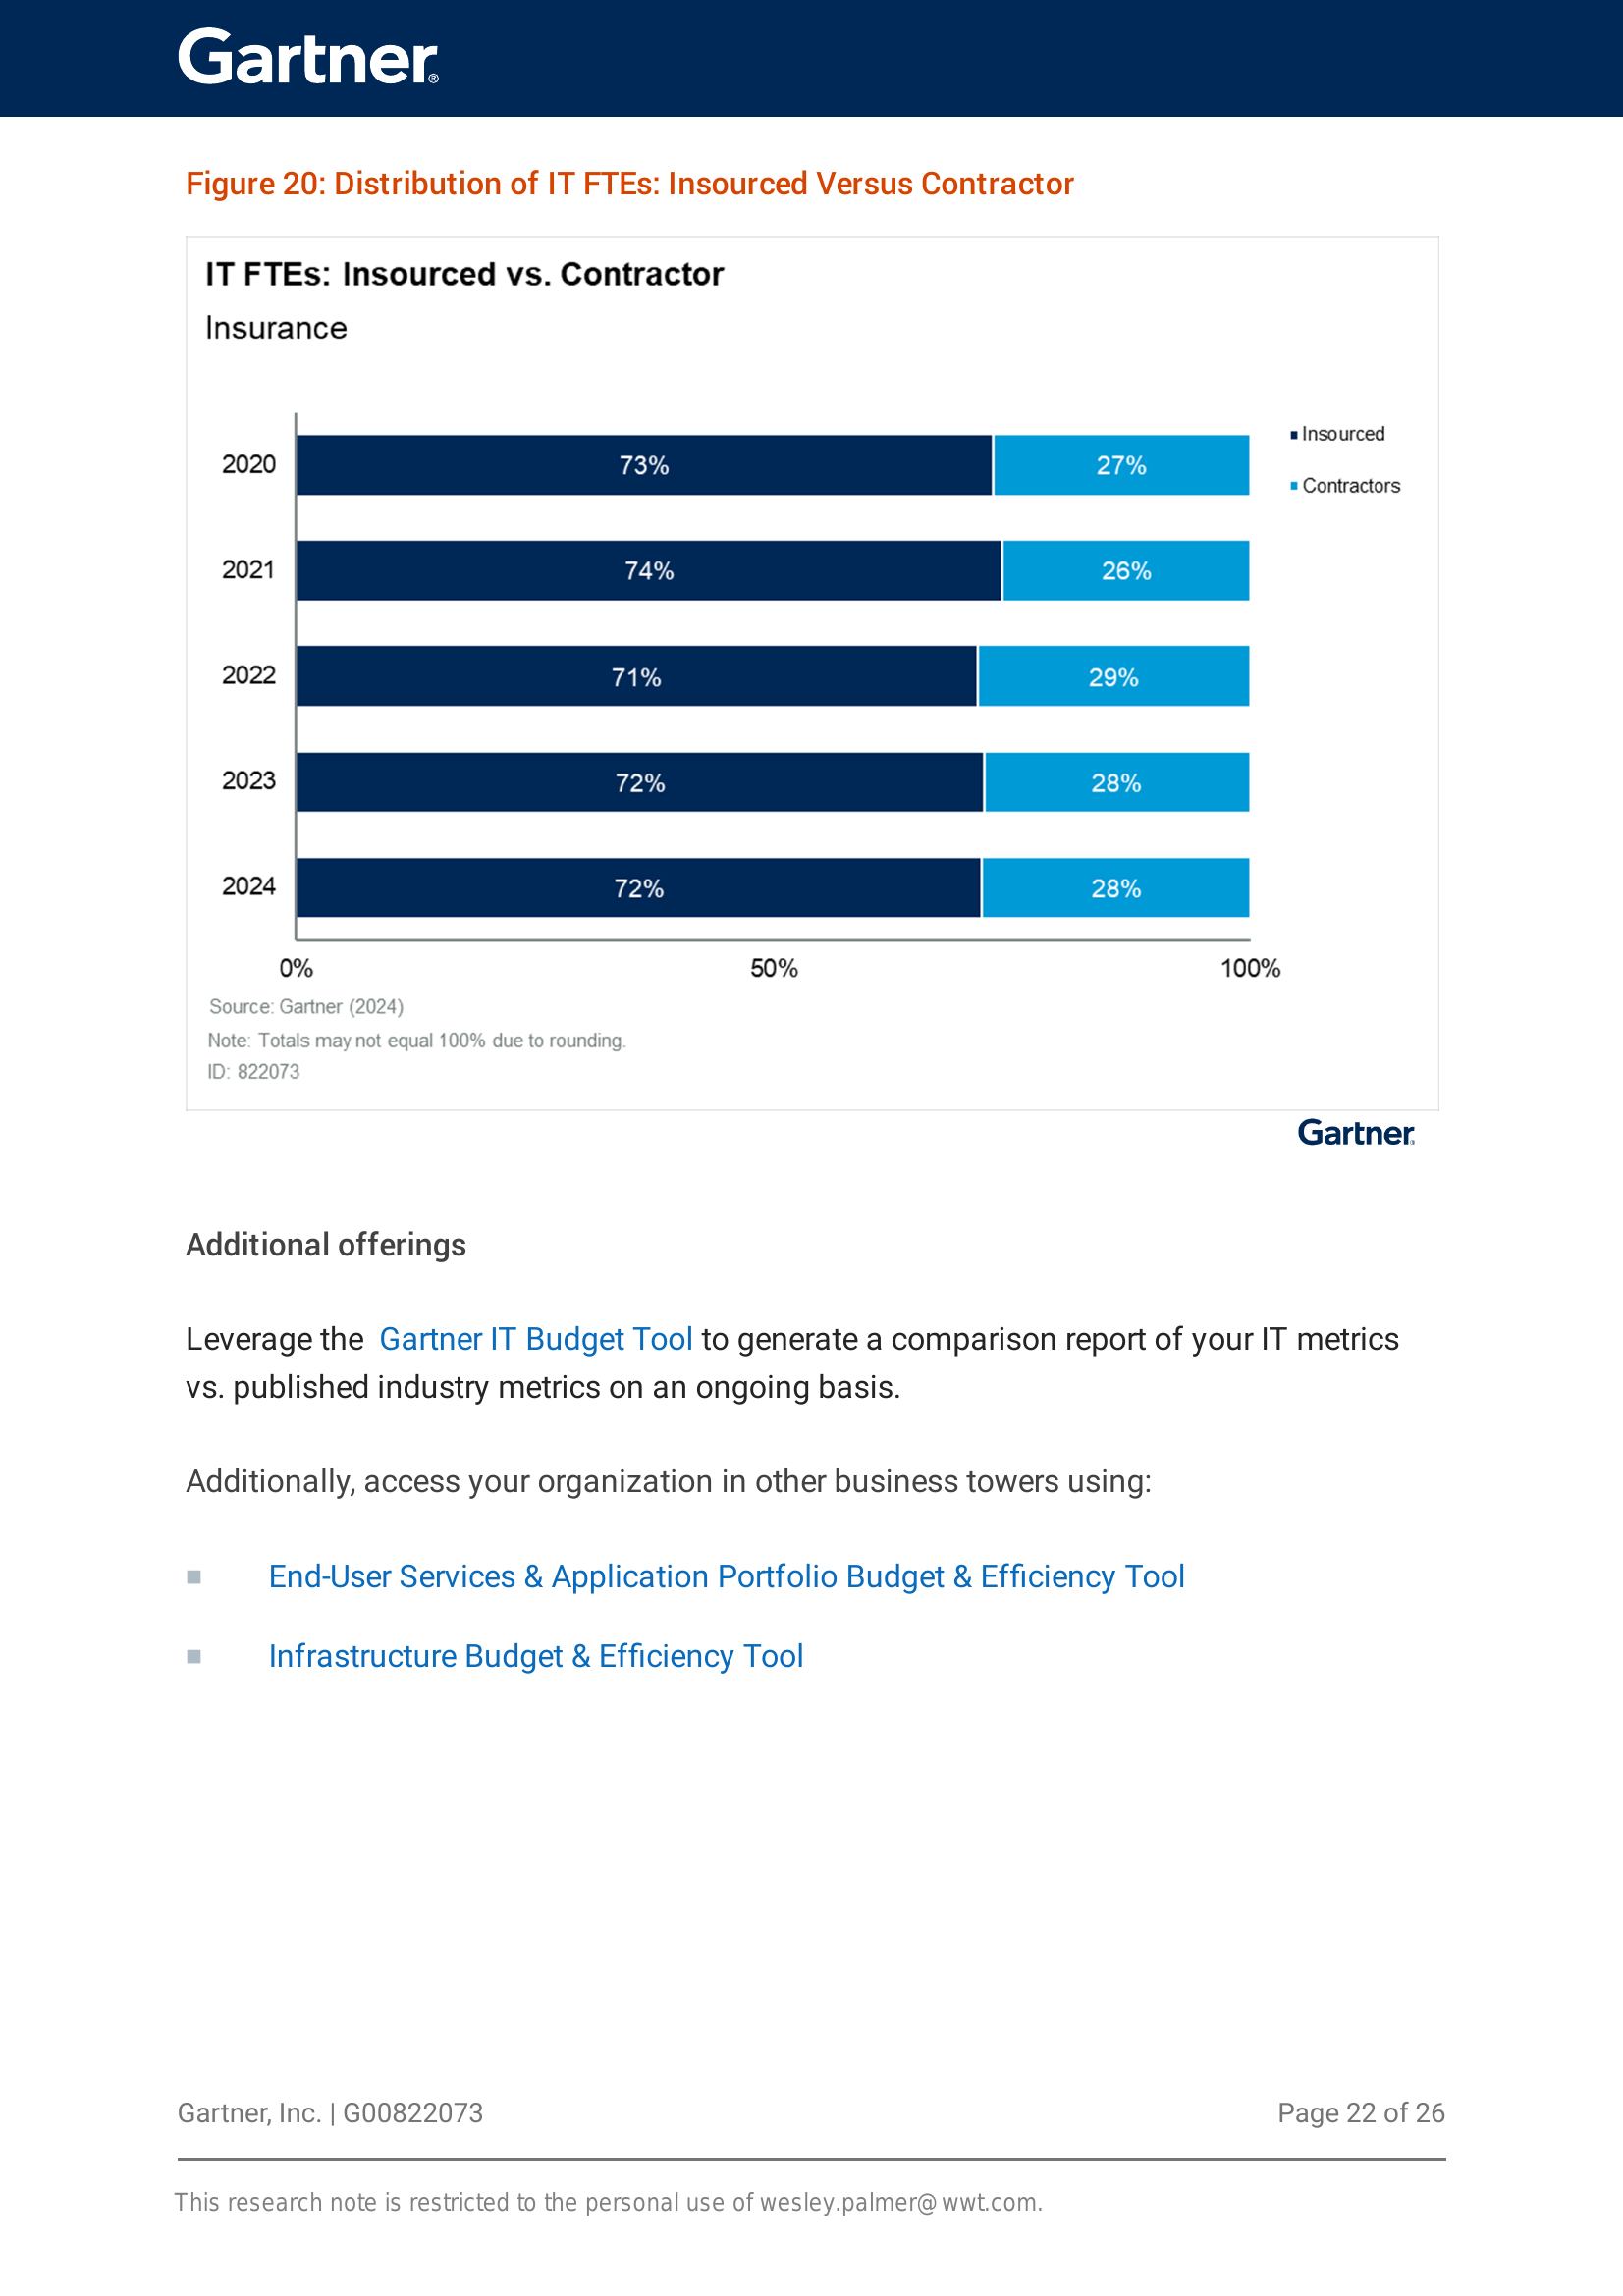

In [18]:
# Show first page
display(images[-6])

## Testing Image analysis with OpenAI

In [19]:
# Initializing OpenAI client - see https://platform.openai.com/docs/quickstart?context=python
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key = api_key)

In [20]:
# Converting images to base64 encoded images in a data URI format to use with the ChatCompletions API
def get_img_uri(img):
    png_buffer = io.BytesIO()
    img.save(png_buffer, format="PNG")
    png_buffer.seek(0)

    base64_png = base64.b64encode(png_buffer.read()).decode('utf-8')

    data_uri = f"data:image/png;base64,{base64_png}"
    return data_uri

In [33]:
system_prompt = '''
You will be provided with an image of a PDF page or a slide. Your goal is to deliver a detailed and engaging presentation about the content you see, using clear and accessible language suitable for a 101-level audience.

If there is an identifiable title, start by stating the title to provide context for your audience.

Describe visual elements in detail:

- **Diagrams**: Explain each component and how they interact. For example, "The process begins with X, which then leads to Y and results in Z."
  
- **Tables**: Break down the information logically. For instance, "Product A costs X dollars, while Product B is priced at Y dollars."

Focus on the content itself rather than the format:

- **DO NOT** include terms referring to the content format.
  
- **DO NOT** mention the content type. Instead, directly discuss the information presented.

Keep your explanation comprehensive yet concise:

- Be exhaustive in describing the content, as your audience cannot see the image.
  
- Exclude irrelevant details such as page numbers or the position of elements on the image.

Use clear and accessible language:

- Explain technical terms or concepts in simple language appropriate for a 101-level audience.

Engage with the content:

- Interpret and analyze the information where appropriate, offering insights to help the audience understand its significance.

------

If there is an identifiable title, present the output in the following format:

{TITLE}

{Content description}

If there is no clear title, simply provide the content description.
'''

def analyze_image(data_uri):
    response = client.chat.completions.create(
        model="gpt-5-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": [
                    {
                    "type": "image_url",
                    "image_url": {
                        "url": f"{data_uri}"
                    }
                    }
                ]
                },
        ],
        #max_tokens=500,
        #temperature=0,
        #top_p=0.1
    )
    return response.choices[0].message.content

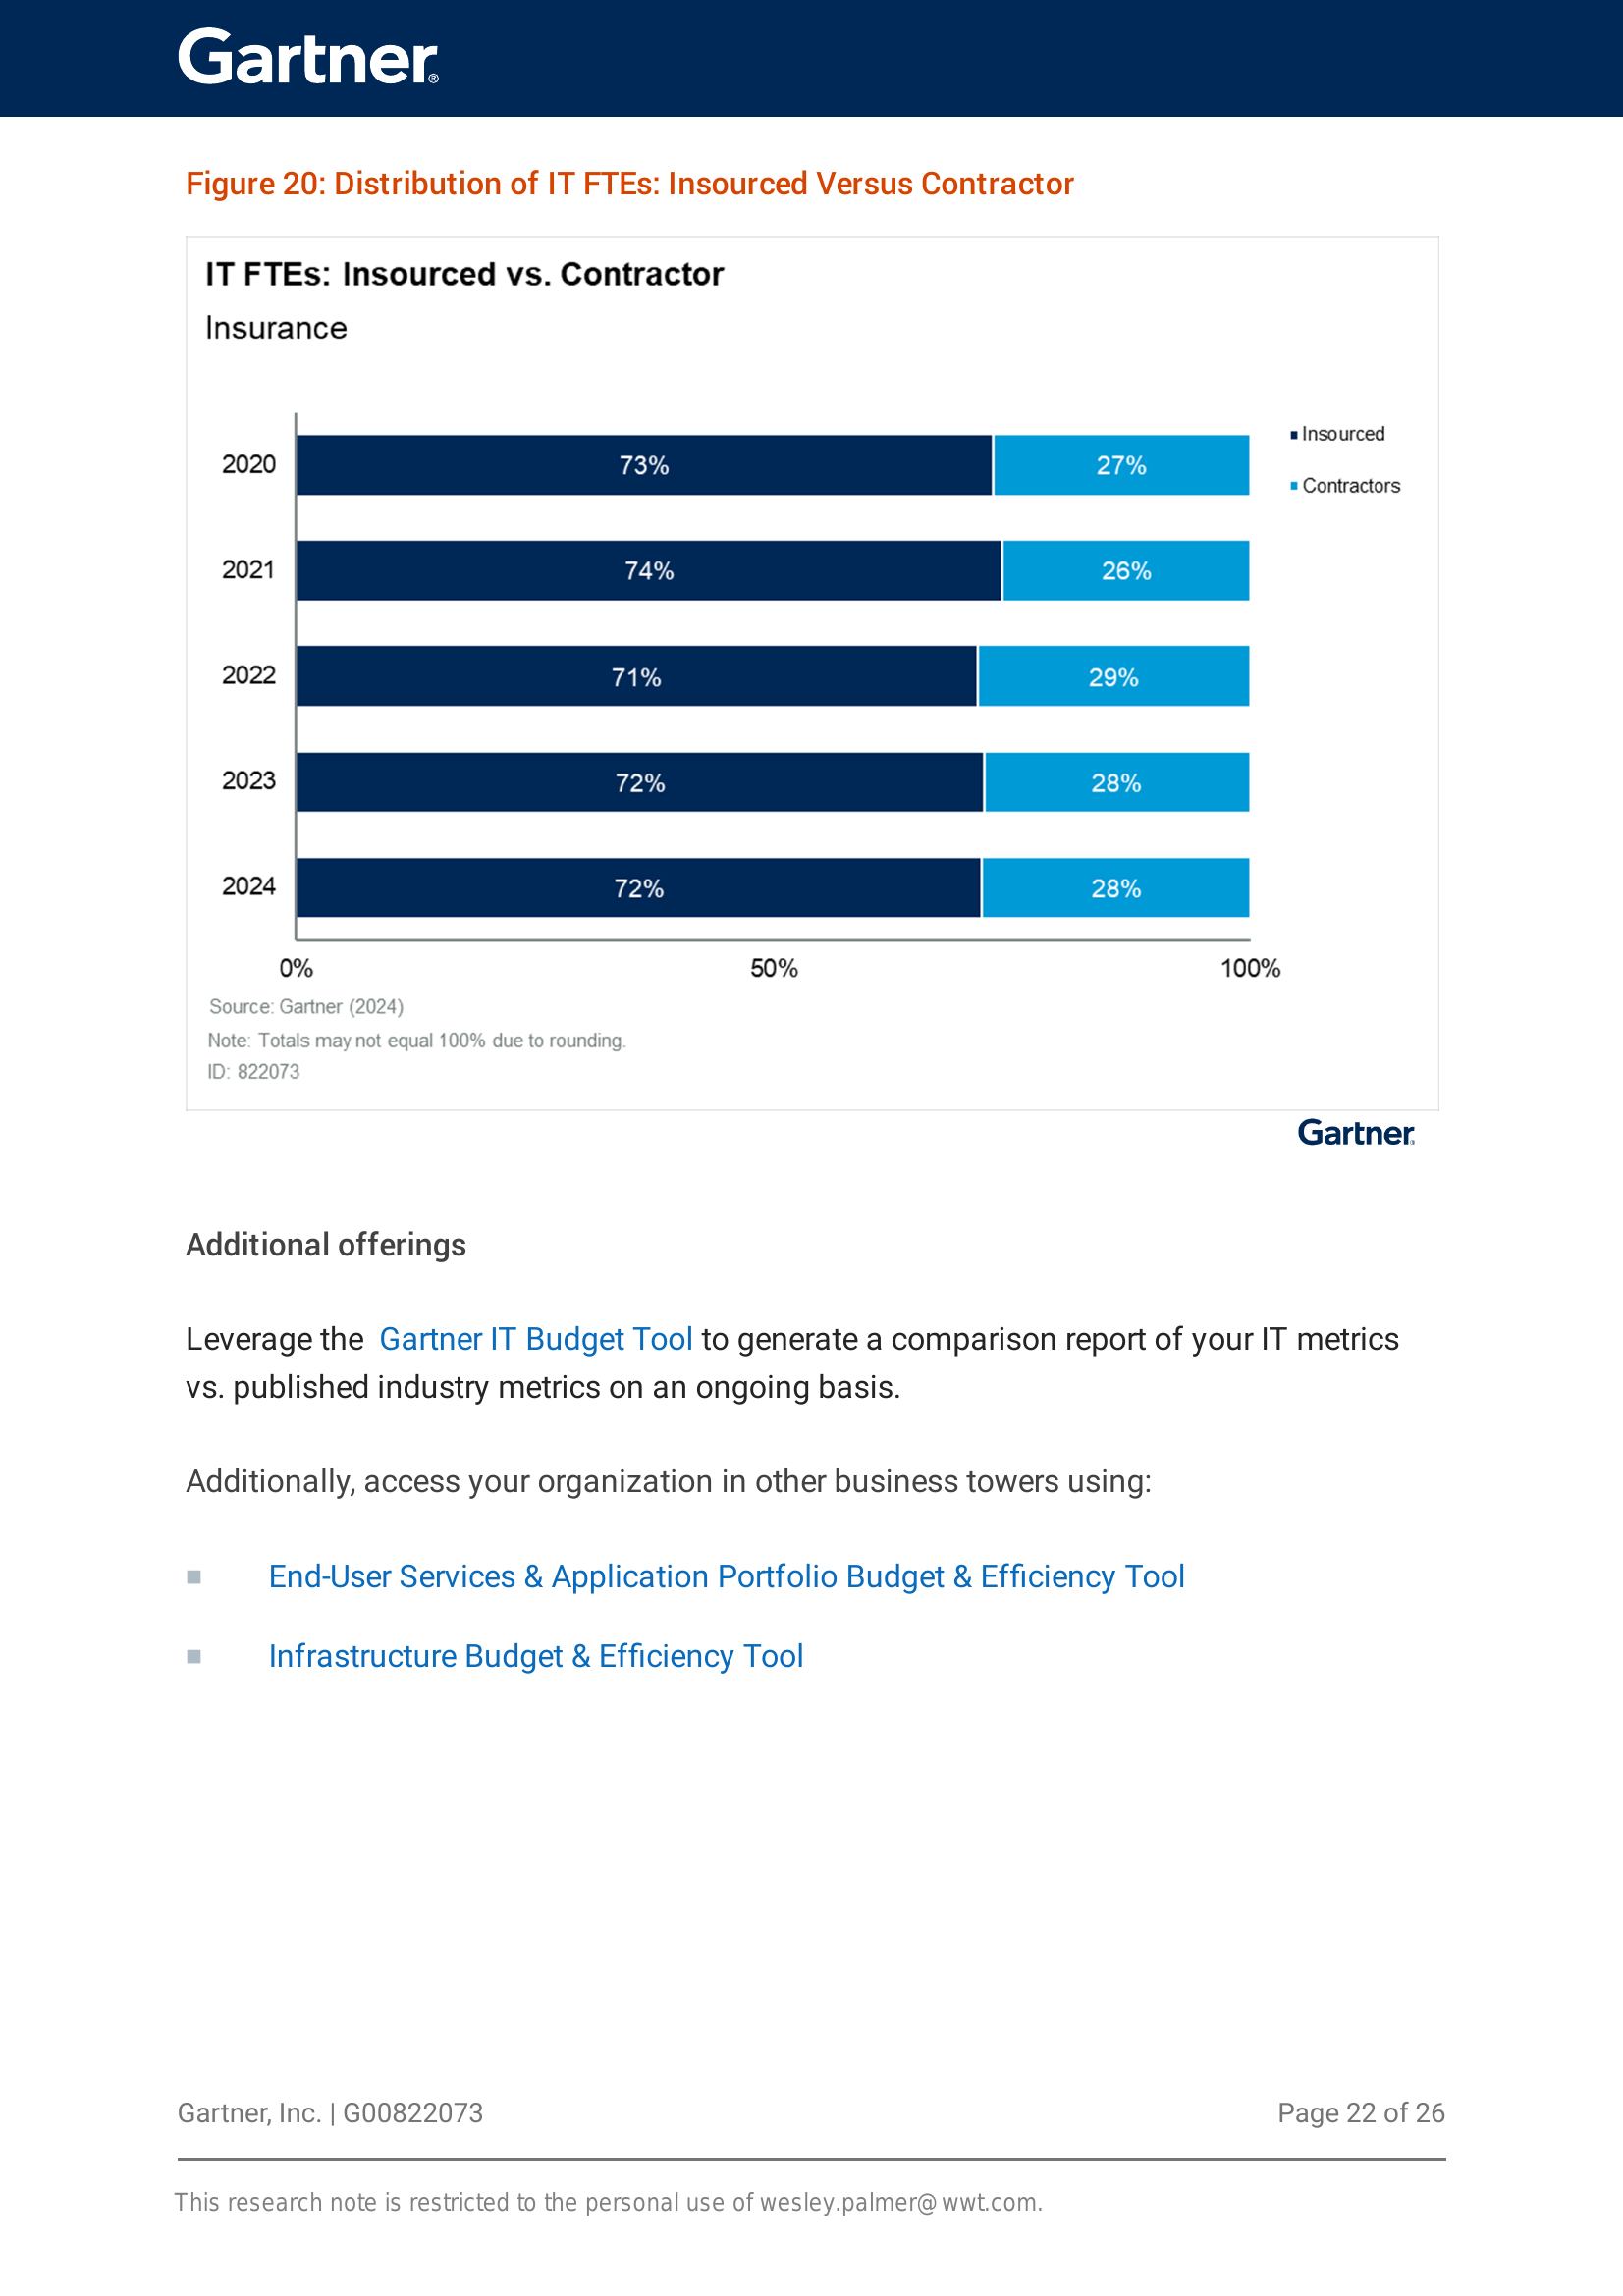

In [34]:
img = images[-6]
display(img)
data_uri = get_img_uri(img)

In [35]:
res = analyze_image(data_uri)
print(res)

Figure 20: Distribution of IT FTEs: Insourced Versus Contractor

This figure shows how IT full-time equivalents (FTEs) in the insurance industry are split between insourced staff 
(internal employees) and contractors (external, temporary or third‑party workers) for the years 2020–2024. The 
chart uses two colors: a dark blue bar for insourced FTEs and a lighter blue bar for contractors. The horizontal 
axis runs from 0% to 100%, representing the full workforce for each year.

Year-by-year breakdown (percent of total IT FTEs)
- 2020: 73% insourced, 27% contractors
- 2021: 74% insourced, 26% contractors
- 2022: 71% insourced, 29% contractors
- 2023: 72% insourced, 28% contractors
- 2024: 72% insourced, 28% contractors

Plain-language interpretation and implications
- Stability: Over the five-year period the insurance sector consistently relies on internal employees for roughly 
71–74% of IT work, with contractors making up about 26–29%. This indicates a stable, long-term preference for an 
insourced workforce.
- 2022 uptick in contracting: Contractor share peaked at 29% in 2022 while insourced dipped to 71%. That could 
reflect temporary responses to specific project demand, labor shortages, or shifting sourcing strategies that year.
- Practical implications: Organizations should plan budgets and workforce strategies that assume roughly 
one-quarter to one-third of IT capacity could come from contractors. That affects recruiting, knowledge transfer, 
vendor management, and total cost of ownership calculations.
- Actionable questions: Are contractor roles mainly for niche skills, surge capacity, or cost flexibility? How well
is knowledge retained when contractor engagements end? Could increased upskilling of insourced staff reduce 
contractor reliance or improve continuity?

Additional offerings described below the chart
- Gartner IT Budget Tool: A tool to generate a comparison report of your IT metrics against published industry 
benchmarks on an ongoing basis.
- Other business-tower tools:
  - End‑User Services & Application Portfolio Budget & Efficiency Tool
  - Infrastructure Budget & Efficiency Tool

Source and note
- Source cited as Gartner (2024). A note indicates totals may not equal exactly 100% because of rounding.

## Doing it on all files in the dataset

In [12]:
dataset = '/domino/datasets/local/Gartner_Article_Chat'
files = [os.path.join(dataset, f) for f in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, f))]

def analyze_doc_image(img):
    img_uri = get_img_uri(img)
    data = analyze_image(img_uri)
    return data

In [13]:
docs = []

for file in files:
    doc_name = file.split('/')[-1]
    
    doc = {'filename':doc_name}

    text = extract_text_from_doc(file)
    doc['text'] = text
    
    images = convert_doc_to_images(file)

    pages_description = []

    print(f'Analyzing pages for doc {doc_name}')

    # Concurrent execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        
        futures = [
            executor.submit(analyze_doc_image, img)
            for img in images
        ]
        
        with tqdm(total=len(images)-1) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(1)
        
        for f in futures:
            res = f.result()
            pages_description.append(res)
        
    doc['pages_description'] = pages_description
    docs.append(doc)

Analyzing pages for doc Banking and Investment Services Business Priority Tracker - 812459 - 2025.pdf

8it [00:31,  3.88s/it]                       


Analyzing pages for doc 2024_CIOs_Reference_Guide_to_Operating-Model_Design_795195_ndx.pdf

 81%|████████  | 38/47 [00:57<00:05,  1.55it/s]

: 

: 